In [1]:
import numpy as np
import pandas as pd
import h5py
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
file = h5py.File("./data/to_stack/pred_res.h5", "r")

In [4]:
train = np.vstack([np.array(file["lgb_all_fea_val"]), 
                   np.array(file["lgb_drop5fea_val"]), 
                   np.array(file["linearReg_std_drop5fea_valid"]), 
                   np.array(file["linearReg_std_valid"]),
                  np.array(file["svr_linear_c042_valid"]), 
                   np.array(file["svr_linear_std_c042_valid"]), 
                   np.array(file["svr_linear_std_drop5fea_c042_valid"])]).T

In [5]:
test = np.vstack([np.array(file["lgb_all_fea_test"]), 
                   np.array(file["lgb_drop5fea_test"]), 
                   np.array(file["linearReg_std_drop5fea_test"]), 
                   np.array(file["linearReg_std_test"]),
                  np.array(file["svr_linear_c042_test"]), 
                   np.array(file["svr_linear_std_c042_test"]), 
                   np.array(file["svr_linear_std_drop5fea_c042_test"])]).T

In [6]:
with open("./data/zhengqi_train.txt")  as file:
    tr=pd.read_table(file, sep="\t")
target = tr["target"]

In [46]:
params_test1={  "learning_rate":np.arange(0.01,0.1,0.01),
                "n_estimators":np.arange(50,1000,50)}
model = lgb.LGBMRegressor(objective='regression',
                            metric='neg_mean_squared_error', 
                          learning_rate=0.03, 
                            n_estimators=200,
                            num_leaves=4,
                            reg_alpha=0.2,
                            reg_lambda=4.3,
                            min_child_samples=10,
                            colsample_bytree =0.7,
                            subsample=0.7,
                            subsample_freq=2,
                            random_state=42
                              )

gsearch = GridSearchCV(estimator=model, param_grid=params_test1, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
gsearch.fit(train, target)

Fitting 5 folds for each of 171 candidates, totalling 855 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 840 out of 855 | elapsed:   29.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 855 out of 855 | elapsed:   30.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       metric='neg_mean_squared_error', min_child_samples=10,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=4, objective='regression', random_state=42,
       reg_alpha=0.2, reg_lambda=4.3, silent=True, subsample=0.7,
       subsample_for_bin=200000, subsample_freq=2),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]), 'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,
       700, 750, 800, 850, 900, 950])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [48]:
score = gsearch.cv_results_["mean_test_score"]

In [50]:
import h5py
file = h5py.File("./data/score_colsample.h5", "w")
file["score_stack_6"] = score
file.close()

In [47]:
gsearch.best_params_

{'learning_rate': 0.03, 'n_estimators': 200}

In [40]:
import matplotlib.pyplot as plt

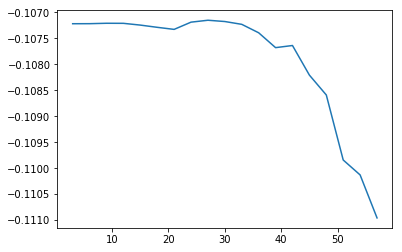

In [45]:
plt.plot(np.arange(3,60,3),score)

In [7]:
model = lgb.LGBMRegressor( learning_rate=0.03, 
                            n_estimators=1000,
                            num_leaves=4,
                            reg_alpha=0.2,
                            reg_lambda=4.3,
                            min_child_samples=10,
                            colsample_bytree =0.7,
                            subsample=0.7,
                            subsample_freq=2,
                            random_state=42)

In [53]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
result_val = np.zeros(shape=(len(train),))
result_test = np.zeros(shape=(len(test),))
for i, (tr_index, val_index) in enumerate(kf.split(train, target)):
    tr_X, val_X = train[tr_index,:], train[val_index,:]
    tr_y, val_y = target[tr_index], target[val_index]
    
    model.fit(X=tr_X, y=tr_y, eval_set=[(val_X, val_y)], eval_metric="mse", early_stopping_rounds=30, verbose=10)

    pred_val_y = model.predict(val_X)
    mse = mean_squared_error(y_pred=pred_val_y, y_true=val_y)
    print("mse:", mse)
    result_val[val_index] = pred_val_y
    pred_test = model.predict(test)
    result_test += pred_test
result_test /=5

Training until validation scores don't improve for 30 rounds.
[10]	valid_0's l2: 0.254002
[20]	valid_0's l2: 0.123495
[30]	valid_0's l2: 0.0974289
[40]	valid_0's l2: 0.0923974
[50]	valid_0's l2: 0.0909589
[60]	valid_0's l2: 0.0912856
[70]	valid_0's l2: 0.0910061
[80]	valid_0's l2: 0.0913172
Early stopping, best iteration is:
[52]	valid_0's l2: 0.0909048
mse: 0.09090479356724428
Training until validation scores don't improve for 30 rounds.
[10]	valid_0's l2: 0.258757
[20]	valid_0's l2: 0.130917
[30]	valid_0's l2: 0.108318
[40]	valid_0's l2: 0.1042
[50]	valid_0's l2: 0.103081
[60]	valid_0's l2: 0.1029
[70]	valid_0's l2: 0.102951
[80]	valid_0's l2: 0.102687
[90]	valid_0's l2: 0.103123
[100]	valid_0's l2: 0.102743
Did not meet early stopping. Best iteration is:
[73]	valid_0's l2: 0.102564
mse: 0.10256385531067957
Training until validation scores don't improve for 30 rounds.
[10]	valid_0's l2: 0.251023
[20]	valid_0's l2: 0.150539
[30]	valid_0's l2: 0.136294
[40]	valid_0's l2: 0.13441
[50]	v

In [52]:
with open("./data/results/submit_stack_bst_para.txt", "w", encoding='utf8') as file:
    for i in result_test:
        file.write(str(i)+"\n")
    file.close()

lgb-bst_parameter
0.09090479356724428
0.10271401095216198
0.1334023921355
0.09892462525724487
0.10106441223317851